In [1]:
import os
import cv2
#openCV appears to be piles and piles of useful stuff
import numpy as np
#maths
from tqdm import tqdm
#far as I can tell just a progress bar for iterables
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


  0%|          | 0/12501 [00:00<?, ?it/s]

PetImages/Cat


  0%|          | 35/12501 [00:00<00:35, 346.74it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:38<00:00, 328.89it/s]


Cats: 12476
Dogs: 12470


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24946


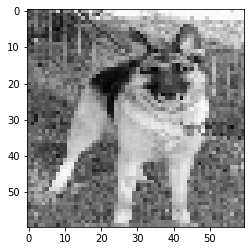

In [3]:
REBUILD_DATA = True

#data processing class 
class DogsVSCats():
    IMG_SIZE = 60
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    
    catcount = 0 
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            #iterating through labels/directories
            for f in tqdm(os.listdir(label)):
                    if "jpg" in f:
                        try:
                            #iterating through images in said directories, along with a progress bar
                            path = os.path.join(label, f)
                            #specifying the paths for each image
                            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                            #reads image and converts it to grayscale
                            img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                            self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        

                            if label == self.CATS:
                                self.catcount += 1
                            elif label == self.DOGS:
                                self.dogcount += 1
                        except Exception as e:
                            pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:', self.catcount)
        print('Dogs:', self.dogcount)
        tqdm._instances.clear()
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
print(DogsVSCats.training_data)

training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

plt.imshow(training_data[1][0], cmap="gray")

In [11]:

#now we make a convolutional NN

class Net(nn.Module):
    def __init__(self):
        super().__init__() #runs init of parent class
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.pool3 = nn.MaxPool2d((2, 2))
        flatten_size = int(((((DogsVSCats().IMG_SIZE - 4)/8)-3)**2)*128) #this has rounding errors, fix
        print(flatten_size)
        self.fc1 = nn.Linear(flatten_size, flatten_size)
        self.fc2 = nn.Linear(flatten_size, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)

net = Net().to(device) #assigning network to either CPU or GPU
print(net)




#choosing optimiser and loss calc. (vectors hence MSE)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()
#Selecting images from training data and putting then in the format Pytorch expects. Then labels
X = torch.Tensor([i[0] for i in training_data]).view(-1, DogsVSCats().IMG_SIZE, DogsVSCats().IMG_SIZE)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
#separating out 10% of data as validation data

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)


train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

BATCH_SIZE = 60
EPOCHS = 5


def train(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, DogsVSCats().IMG_SIZE, DogsVSCats().IMG_SIZE)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            
            matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
            in_sample_acc = matches.count(True)/len(matches)
            
            
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")
        print("In sample acc:",round(in_sample_acc, 2))



def test(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, DogsVSCats().IMG_SIZE, DogsVSCats().IMG_SIZE).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))
    
    for i in range(3):
        plt.imshow(X[i].view(DogsVSCats().IMG_SIZE, DogsVSCats().IMG_SIZE), cmap='gray')
        plt.show()
        if torch.argmax(net(test_X[i].view(-1, 1, DogsVSCats().IMG_SIZE, DogsVSCats().IMG_SIZE).to(device))[0]).item() == 1:
            print("dog")
        else:
            print("cat")

2048
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2, bias=True)
)


In [12]:
train(net)


100%|██████████| 375/375 [00:31<00:00, 11.83it/s]

  1%|          | 2/375 [00:00<00:25, 14.71it/s]

Epoch: 0. Loss: 0.19752860069274902
In sample acc: 0.67



100%|██████████| 375/375 [00:31<00:00, 11.87it/s]

  1%|          | 2/375 [00:00<00:25, 14.50it/s]

Epoch: 1. Loss: 0.15455375611782074
In sample acc: 0.83



100%|██████████| 375/375 [00:31<00:00, 11.87it/s]

  1%|          | 2/375 [00:00<00:26, 14.29it/s]

Epoch: 2. Loss: 0.10288083553314209
In sample acc: 0.92



100%|██████████| 375/375 [00:32<00:00, 11.68it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.0926445946097374
In sample acc: 0.92



100%|██████████| 375/375 [00:33<00:00, 11.08it/s]

Epoch: 4. Loss: 0.0607365220785141
In sample acc: 0.92



100%|██████████| 2494/2494 [00:10<00:00, 236.08it/s]


Accuracy:  0.749


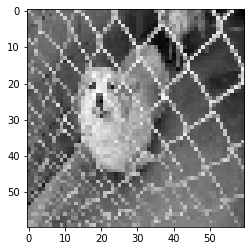

cat


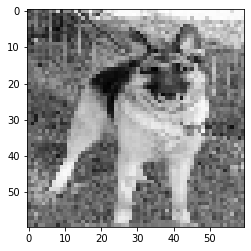

cat


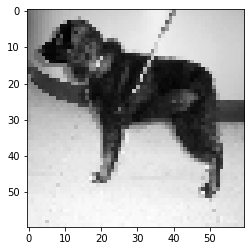

dog


In [13]:
test(net)